### **Langgraph Tool 활용 기초** ###

### 랭그래프에서 Tool을 어떤식으로 활용해야 될까?
LLM이 판단하기에 본인이 직접 답변하기 어려운 경우 Tool을 활용하도록 만들어 줄 수가 있다.
만약에 Tool이 이 시스템안에 등록이 되어 있지 않다면 어떤 질문이 왔는데 (예를 들어 가장 최신의 질문이나 답변하기 어려운 질문 같은것)
LLM이 스스로 판단하기에 잘 모르는 부분이면 모른다고 하는게 아닌 엉뚱한 정보를 알려줄 수 있다.
이를 환각현상 이라고 한다. (모르지만 아는 것처럼 엉뚱한 정보나 거짓된 정보를 줄 수 있음)

하지만 도구를 결합해서 LLM이 도구를 활용할 수 있도록 어떤 조치를 취해주면 최신질문이나 자세한 정보, 실시간 정보
이런 외부에 도움이 필요한 질문을 했을 때 LLM이 나는 도구를 필요로 하고 있고 웹서치를 활용해야 겠다는 판단이 들게 되면,
웹 서치가 있는 Tool Node를 들어가서 Tool Node를 실행한 결과를 받아 사용자에게 정리된 답변을 전달하는 방식으로 Tool을 활용하게 된다.

이 과정에서 만약에 Tool을 사용하지 않고도 LLM이 출분히 답변할 수 있는 상황이면 그렇게 하고,
그게 아니고 답변이 어려운 경우 Tool활용을 선택적으로 사용할 수 있도록 만들어 주면된다.

엣지를 어떤식으로 설정해야 하는지도 한번 살펴보자

In [1]:
from dotenv import load_dotenv

load_dotenv()

ModuleNotFoundError: No module named 'dotenv'

In [111]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool # Tool라이브러리 가져오기

from langgraph.prebuilt import ToolNode # Tool들을 선언해주고 실제로 그래프 내에서 활용할 수 있는 노드로 변환을 시켜주는 라이브러리 가져오기

#### **Langgraph Custom Tool 선언** ####

외부API를 결합하는게 아닌
기초적으로 어떤 가상의 답변을 내놓은 함수를 Tool로 만들어서 활용해보기

In [113]:
#langchain_core.tools의 tool을 import하면 @tool 데코레이터만으로 함수를 langchain의 tool로 변환할 수 있다.
#아래 날씨 관련 함수들은 임의의 로직이므로, 실제 함수는 API를 포함한 로직이 들어가면 된다.

# tool 데코레이터(@)를 달고 함수를 작성해주면 된다.

# 1. 날씨를 출력해주는 함수
@tool
def get_weather(location: str): # 입력값은 location이고 타입은 string 선언
    """Call to get the weather""" # 이 부분은 docString을 적어주어 agent가 어떤 도구를 사용해야 할지 선택할 때 힌트로써 활용하게 된다. (날씨를 알아보기에 좋은 도구다)
    if location in ["서울", "인천"]:
        return "It's 60 degrees and foggy." # 입력값으로 서울이나 인천이 들어오면 반환
    else:
        return "It's 90 degrees and sunny." # 둘 다 아니면 이 부분 반환
    # 실제로 날씨 API를 불러온건 아니지만 그렇다고 하는 경우에 이런식으로 만들어 볼 수 있다. 예시함수

# 2. 가장 추운 도시들을 출력해주는 함수
@tool
def get_coolest_cities(): # 아무런 입력값을 받지않고 출력
    """Get a list of coolest cities"""
    return "서울, 고성"

In [115]:
#Tool Node로 묶어줄 때, 리스트 형태로 tool들을 함께 제공합니다.
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools) # aget가 ToolNode로 요청을 보냈을 때 ToolNode에 있는 여러가지 툴들 중에 어떤 툴을 부르는건지 어떤식으로 실행하는지에 대해서 자세히 알 수 있게된다.

In [ ]:
#bind_tools() 함수로 LLM에게 어떤 tool들이 있는지 인지시켜 도구를 활용하도록 만듭니다.
from langchain_openai import ChatOpenAI

model_with_tools = ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).bind_tools(tools) # ai를 그냥 불러오는게 아닌 bind_tools로 어떤 도구들이 있는지 힌트를 줄 수 있게끔 만들어줌
                    # gpt-4o-mini 모델은 tools를 살펴보고 이런 도구들을 가지고 있구나 인지하게됨

In [127]:
model_with_tools.invoke("서울 날씨는 어때?").tool_calls

[{'name': 'get_weather',
  'args': {'location': '서울'},
  'id': 'call_HmyqZSrjgHd0p59ePE1Ll9kZ',
  'type': 'tool_call'}]

In [125]:
model_with_tools.invoke("한국에서 가장 추운 도시는?").tool_calls

[{'name': 'get_coolest_cities',
  'args': {},
  'id': 'call_lt9B0z9aILHS2HHJCyId5F7G',
  'type': 'tool_call'}]

In [129]:
tool_node.invoke({"messages": [model_with_tools.invoke("서울 날씨는 어때?")]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='call_k7S04S37SUlIhe5jdyw9zJIb')]}

#### **노드, 엣지를 선언하고 그래프 정의하기** ####

실제로 어떤식으로 그래프에서 작동하는지 살펴보자

In [131]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState

def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

# add_conditional_edges는 조건부 엣지 추가 함수입니다.
#아래 conditional_edge는 should_continue라는 함수에 따라 agent 노드에서 tool 혹은 end로 진입시킵니다.
# def should_continue(state: MessagesState) -> Literal["tools", END]:
#     messages = state['messages']
#     last_message = messages[-1]
#     # If the LLM makes a tool call, then we route to the "tools" node
#     if last_message.tool_calls:
#         return "tools"
#     # Otherwise, we stop (reply to the user)
#     return END

workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", 'agent')

app = workflow.compile()

#### **그래프 시각화** ####

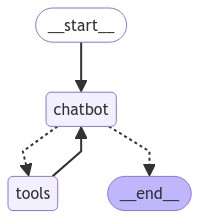

In [133]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### **invoke 함수로 그래프 호출하기** ####

In [135]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="서울의 날씨는 어때?")]}
)
final_state["messages"][-1].content

'서울의 날씨는 60도(약 15도)이며 안개가 낀 상태입니다.'

In [137]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "가장 추운 도시의 날씨는 어때?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

가장 추운 도시의 날씨는 어때?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_KVq9iOM6UMURVnYj2VvydHid)
 Call ID: call_KVq9iOM6UMURVnYj2VvydHid
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

서울, 고성
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_o7SnhRLJXxugmPw1UNseAcfE)
 Call ID: call_o7SnhRLJXxugmPw1UNseAcfE
  Args:
    location: 서울
  get_weather (call_OaKLeEcLz2PgxMusCjMaxQsf)
 Call ID: call_OaKLeEcLz2PgxMusCjMaxQsf
  Args:
    location: 고성
================================= Tool Message =================================
Name: get_weather

It's 90 degrees and sunny.
================================== Ai Message ==================================

가장 추운 도시인 서울의 날씨는 60도(약 15도)로 안개가 끼어 있습니다. 반면, 고성의 날씨는 90도(약 32도)로 맑